In [1]:
from pprint import pformat

import networkx as nx
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
# default parameters
API_URL = "https://api.epigraphdb.org"
print(API_URL)
requests.get(f"{API_URL}/ping").json()

https://api.epigraphdb.org


True

In [3]:
endpoint = "/meta/schema"
params = {"graphviz": False, "plot": False}
r = requests.get(f"{API_URL}{endpoint}", params=params)
r.raise_for_status()
metadata = r.json()

# Preview of metadata information
keys = metadata.keys()
print(pformat(keys), "\n")
# for key in list(keys):
#     print(f"# {key}:")
#     print(pformat(metadata[key])[:1000], "\n")

dict_keys(['nodes', 'edges', 'connections']) 



In [ ]:
# metadata

### Extract metadata to understand structure

In [4]:
meta_node_df = pd.DataFrame.from_dict(metadata['nodes'], orient="index")
meta_node_df= meta_node_df.sort_index().assign(count=lambda df: df["count"].apply(lambda x: f"{x:,}"))
meta_node_df['count']

Disease                38,960
Drug                    2,697
Efo                    25,390
Gene                   57,737
Gwas                   34,494
Literature          3,995,672
LiteratureTerm        108,905
LiteratureTriple    5,609,945
Pathway                 2,441
Protein                20,280
Tissue                     54
Variant                99,005
Name: count, dtype: object

In [5]:
r = requests.get(f"{API_URL}/meta/nodes/id-name-schema")
r.raise_for_status()
meta_node_fields = r.json()
pd.DataFrame.from_dict(meta_node_fields, orient="index")

,id,name
Disease,id,label
Drug,label,label
Efo,id,value
Gene,ensembl_id,name
Gwas,id,trait
Literature,id,id
LiteratureTerm,id,name
LiteratureTriple,id,name
Pathway,id,name
Protein,uniprot_id,uniprot_id


In [6]:
meta_rel_df = pd.DataFrame.from_dict(metadata["edges"], orient="index").merge(
    pd.DataFrame.from_dict(
        {_["rel"]: _ for _ in metadata["connections"]}, orient="index"
    )[["from_node", "to_node"]],
    left_index=True,
    right_index=True,)
meta_rel_df = meta_rel_df.sort_values(by=["from_node", "to_node"]).assign(
        count=lambda df: df["count"].apply(lambda x: f"{x:,}"))
# meta_rel_df[['count', 'from_node', 'to_node']]

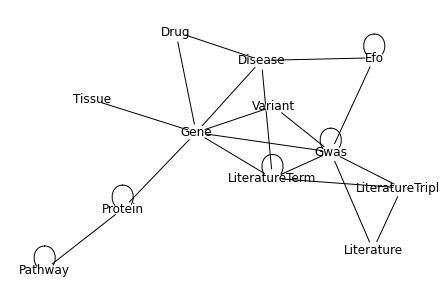

In [7]:
graph = nx.from_pandas_edgelist(meta_rel_df, source="from_node", target="to_node")
nx.draw(
    G=graph,
    pos=nx.kamada_kawai_layout(graph),
    with_labels=True,
    node_color="white",
)

1. Gwas: A database of 244,618,939,051 genetic associations from 42,333 GWAS summary datasets, for querying or download.
2. Multiple disease entries arise from the mapping between the trait name and EFO terms, each of which maps to a disease term
3. The Experimental Factor Ontology (EFO) provides a systematic description of many experimental variables available in EBI databases, and for projects such as the GWAS catalog. 



we need to know what the "ID" and "name" fields are for the meta nodes using GET /meta/nodes/id-name-schema:

### How to get a sub-graph given a disease name?

In [8]:
API_URL = "https://melodi-presto.mrcieu.ac.uk/api/"
requests.get(f"{API_URL}/status").json()

True

In [9]:
#enrich
def enrich(q):
    endpoint = "/enrich/"
    url = f"{API_URL}{endpoint}"
    params = {
        "query": q,
    }
    response = requests.post(url, data=json.dumps(params))
    try:
        res = response.json()
        enrich_df = (
                pd.json_normalize(res)
        )
        return enrich_df
    except:
        print('No data')
        return []
    
#overlap
def overlap(q1,q2):
    endpoint = "/overlap/"
    url = f"{API_URL}{endpoint}"
    params = {
        "x": q1,
        "y": q2,
    }
    response = requests.post(url, data=json.dumps(params))
    res = response.json()
    if 'data' in res:
        overlap_df = (    
            pd.json_normalize(res['data'])
        )
    else:
        overlap_df=pd.DataFrame()
    return overlap_df

# remove duplicates
def pub_check(row):
    px = set(row['pmids_x'].split(' '))
    py = set(row['pmids_y'].split(' '))
    check=[]
    if len(px.intersection(py)) > 0: 
        return False
    else:
        return True

In [12]:
# query_term='atopic dermatitis'
query_term='skin disease'
enrich_df = enrich(query_term)
# enrich_df.head(2)
enrich_df[['query', 'subject_id', 'object_id', 'subject_name','predicate', 'object_name', 'object_type', 'pmids']]

,query,subject_id,object_id,subject_name,predicate,object_name,object_type,pmids
0,skin_disease,C0165032,C0033860,imiquimod,CAUSES,Psoriasis,dsyn,33895291 33876753 33858431 33834031 33775808 3...
1,skin_disease,C0005522,C0033860,Biological Products,TREATS,Psoriasis,dsyn,31821860 31801012 31786732 31778205 31764836 3...
2,skin_disease,C0025677,C0033860,Methotrexate,TREATS,Psoriasis,dsyn,31715016 31678057 31651148 31571573 31424714 3...
3,skin_disease,C0022265,C0702166,Isotretinoin,TREATS,Acne,dsyn,31765029 31691769 31613567 31502795 31498706 3...
4,skin_disease,C0717758,C0033860,Etanercept,TREATS,Psoriasis,dsyn,31820498 31627849 31562785 31240322 31094242 3...
...,...,...,...,...,...,...,...,...
44612,skin_disease,C0012403,C0037903,Dimethyl Sulfoxide,INTERACTS_WITH,SPHINGOMYELINASE,aapp,2983689
44613,skin_disease,C0039654,C0030242,Tetradecanoylphorbol Acetate,STIMULATES,Palmitoylcarnitine,gngm,3081251
44614,skin_disease,C0034786|367,C0037274,Androgen Receptor|AR,AUGMENTS,skin disorder,dsyn,2959494
44615,skin_disease,C0596577,C0023837,Flavonoids,INHIBITS,Lipoxygenase,gngm,6427052


write the skin disease data subset to csv for graph embedding step

In [28]:
df_download = enrich_df[['subject_id', 'object_id', 'subject_name','predicate', 'object_name']]
df_download.shape
# df_download.to_csv("/content/drive/MyDrive/KG creation/Medical /semmeddb_triples.csv")

In [24]:
# import difflib 
# enrich_df[enrich_df['subject_name'] == 'Dermatitis, Atopic'].head()

In [ ]:
enrich_df = enrich_df.loc[enrich_df.predicate == 'TREATS']
# graph = nx.from_pandas_edgelist(enrich_df, source="subject_name", target="object_name")
# nx.draw(
#     G=graph,
#     pos=nx.circular_layout(graph),
#     with_labels=True,
#     node_color="white",
# )


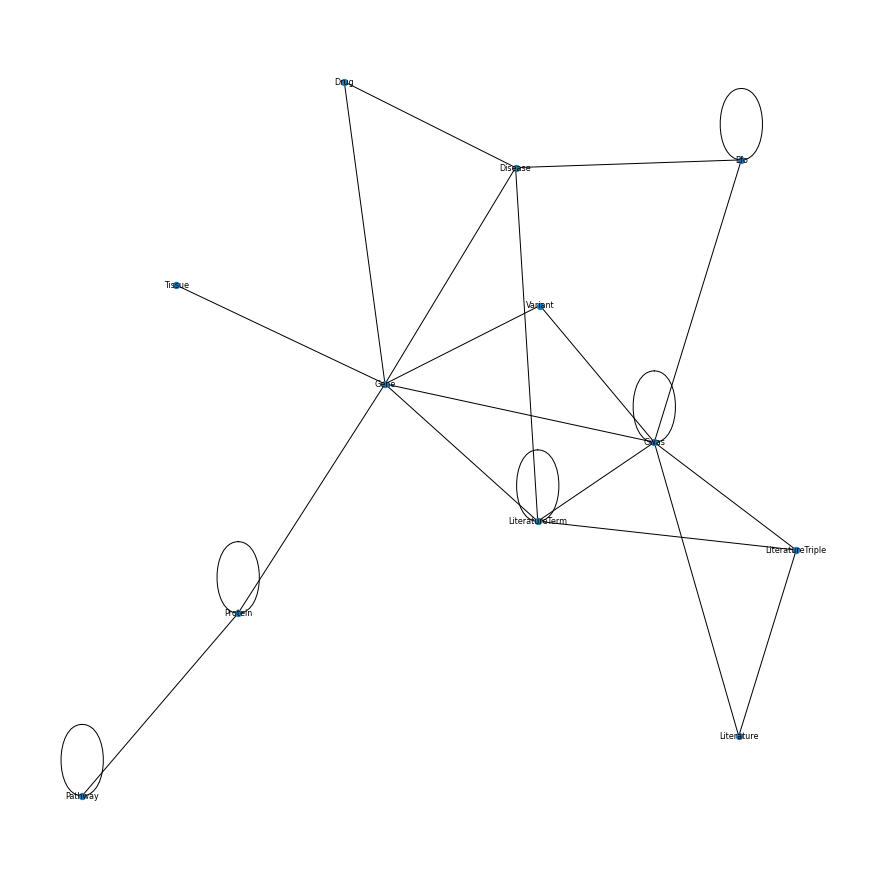

In [ ]:
G = graph
pos = nx.kamada_kawai_layout(G)

# larger figure size
plt.figure(3,figsize=(12,12)) 
nx.draw(G,pos,with_labels=True,node_size=40,font_size=8)
plt.show()

About the disease

In [ ]:
# Parameters
API_URL = "https://api.epigraphdb.org"
# Here we use the .get() method to send a GET request to the /ping endpoint of the API
print(API_URL)
endpoint = "/ping"
response_object = requests.get(API_URL + endpoint)

# Check that the ping was sucessful
try:
    response_object.raise_for_status()
    print("If this line gets printed, ping was sucessful.")
except requests.exceptions.HTTPError as err:
    print(err)

https://api.epigraphdb.org
If this line gets printed, ping was sucessful.


In [ ]:
# 4.1 Getting a list of available meta-nodes

# Send the request
endpoint = "/meta/nodes/list"
response_object = requests.get(API_URL + endpoint)
response_object.raise_for_status()

# Store the results of the query and display
result = response_object.json()

result

['Disease',
 'Drug',
 'Efo',
 'Gene',
 'Gwas',
 'Literature',
 'LiteratureTerm',
 'Pathway',
 'Protein',
 'Tissue',
 'Variant']

In [ ]:
# Set params
params = {"name": "dermatitis"}
# Make request
meta_node = "Disease"
endpoint = f"/meta/nodes/{meta_node}/search"
response_object = requests.get(API_URL + endpoint, params=params)
response_object.raise_for_status()
# Convert to pandas
results = pd.json_normalize(response_object.json()["results"])
pd.options.display.max_colwidth = 100
results
pprint(results['node.definition'])
# target_node_id = results["node.id"]#[3]  # Store one ID for use in the next cell
# target_node_id
# results[["node.trait", "node.id", "node.sample_size", "node.year", "node.author"]]

0    Seborrheic dermatitis is a form of eczema which is closely related to dandruff. It causes dry or...
1    Cutaneous eruptions resembling acne, characterized by the presence of papulonodules, pustules, c...
2    An inflammatory skin condition affecting children. It is often associated with Epstein-Barr viru...
3    An acrodermatitis characterized by a chronically progressive course, leading to widespread atrop...
4                                                                                                     NA
5    Acrodermatitis enteropathica (AE) is a rare inherited inborn error of metabolism resulting in a ...
6    Agammaglobulinemia-microcephaly-craniosynostosis-severe dermatitis syndrome combines agammaglobu...
7    An inflammatory skin condition caused by an immune response to direct contact between the skin a...
8                                                A allergic contact dermatitis that involves the eyelid.
9                     Any atopic eczema in which the ca

#### Publicaton data

We can retrive the SemMedDB data for a give PubMed ID

In [ ]:
def sentence(q):
    endpoint = "/sentence/"
    url = f"{API_URL}{endpoint}"
    params = {
        "pmid": pmid,
    }
    response = requests.post(url, data=json.dumps(params))
    res = response.json()
    pub_df = (
        pd.json_normalize(res['data'])
    )
    return pub_df


In [ ]:
pmid = '33837558'
pub_df = sentence(pmid)
pub_df

JSONDecodeError: ignored

In [ ]:
# Parameters
API_URL = "https://api.epigraphdb.org"
name = "eczema"

# r = requests.get(f"{API_URL}/meta/nodes/Gwas/search", params={"name": name})
r = requests.get(f"{API_URL}/meta/nodes/Gwas/search", params={"name": name})
r.raise_for_status()
t = r.json()
# Preview of metadata information
keys = t.keys()
print(pformat(keys), "\n")

print(pformat(t)[:9000])

In [ ]:
df = pd.json_normalize(t['results'])
df.head()

In [ ]:
# # Parameters
# API_URL = "http://dev.epigraphdb.org/search?meta_node=Disease&q=C0011615"
# # Here we use the .get() method to send a GET request to the /ping endpoint of the API
# print(API_URL)
# endpoint = "/ping"
# response_object = requests.get(API_URL)

# # Check that the ping was sucessful
# try:
#     response_object.raise_for_status()
#     print(response_object.json())
# except requests.exceptions.HTTPError as err:
#     print(err)
# # print(requests.get(API_URL).json())

In [ ]:
# # Set params
# params = {"name": "C0011615"}
# meta_node = "Disease"
# # Parameters
# API_URL = "http://dev.epigraphdb.org"
# name = "C0011615"
# #http://dev.epigraphdb.org/search?meta_node=Disease&q=C0011615
# # r = requests.get(f"{API_URL}/meta/nodes/Gwas/search", params={"name": name})
# r = requests.get(f"{API_URL}/search?meta_node={meta_node}&q={name}")
# r.raise_for_status()
# print(r.json())